This notebook benchmarks how well clinical suspicion does for predicting IAI-I. It only uses data from PECARN.

In [28]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
from os.path import join as oj
import pandas as pd
import helper
import matplotlib.pyplot as plt

df = pd.read_csv('df_pecarn.csv')

# add ai prediction
yhat_pred_probabilistic, yhat_pred_binary = helper.pecarn_rule_predict(df, o='iai_intervention', verbose=False)
df['ai_prediction_pecarn'] = yhat_pred_probabilistic

# map physician values to probabilities
df['physician_prediction'] = df['IAIAcuteInterv'].map({
    1.0: 0.5,
    2.0: 3,
    3.0: 8,
    4.0: 30.5,
    5.0: 75,
    6.0: 0
})
meanings = ['<1%', '1-5%', '6-10%', '11-50%', ">50%", 'Physician did not answer']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here, we want to compare 4 things:
1. `iai_intervention` - the groundtruth outcome: binary
2. `ai_prediction_pecarn` - prediction by the clinical decision rule: probabilistic (`physician_prediction` maps these to probabilities)
3. `IAIAcuteInterv` - Clinical suspicion for IAI in need of acute intervention (split into 5 levels)
4. `IAISuspicion` - Clinical suspicion for the presence of IAI identified on CT (split into 5 levels)

# Compare performance of all variables

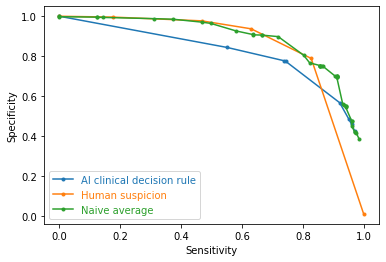

In [33]:
df['test'] = 0.5 * df['IAIAcuteInterv'] * 0.5 * df['ai_prediction_pecarn']
legend = {
    'ai_prediction_pecarn': 'AI clinical decision rule',
    'physician_prediction': 'Human suspicion',
    'test': 'Naive average'
}
for k in sorted(legend.keys()):
    stats, threshes = helper.all_stats_curve(df['iai_intervention'], df[k])

    plt.plot(stats['sens'], stats['spec'], '.-', label=legend[k])
    plt.xlabel('Sensitivity')
    plt.ylabel('Specificity')
plt.legend(labelcolor='linecolor')
plt.show()

# Breakdown of clinician variables

In [2]:
y = df['iai_intervention']
meanings = ['<1%', '1-5%', '6-10%', '11-50%', ">50%", 'Physician did not answer']
y1 = df['IAISuspicion'].values
y2 = df['IAIAcuteInterv'].values

IAIAcuteInterv - Clinical suspicion for IAI in need of acute intervention (split into 5 levels)

In [5]:
print('Score\tiaiw/i\tTot\tPerc\tPhysician Target')
for i in range(1, 7):
    num_iai = np.sum(y[y2==i])
    num_tot = np.size(y[y2==i])
    print(f'{i}\t{num_iai} \t {num_tot}\t{100 * num_iai/num_tot:0.2f}\t {meanings[i - 1]}')

Score	iaiw/i	Tot	Perc	Physician Target
1	35 	 9252	0.38	 <1%
2	40 	 1793	2.23	 1-5%
3	33 	 506	6.52	 6-10%
4	59 	 281	21.00	 11-50%
5	36 	 87	41.38	 >50%
6	0 	 125	0.00	 Physician did not answer


IAISuspicion: Clinical suspicion for the presence of IAI identified on CT (split into 5 levels)

In [6]:
print('Score\tiai-i\tTot\tPerc\tPhysician Target')

for i in range(1, 7):
    num_iai = np.sum(y[y1==i])
    num_tot = np.size(y[y1==i])
    print(f'{i}\t{num_iai} \t {num_tot}\t{100 * num_iai/num_tot:0.2f}\t {meanings[i - 1]}')

Score	iai-i	Tot	Perc	Physician Target
1	10 	 6591	0.15	 <1%
2	23 	 3124	0.74	 1-5%
3	30 	 1166	2.57	 6-10%
4	63 	 758	8.31	 11-50%
5	77 	 298	25.84	 >50%
6	0 	 107	0.00	 Physician did not answer
